In [36]:
import copy
import os
import collections

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline
import pymatgen.ext.matproj
import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
import DigitalEcosystem.utils.misc
import DigitalEcosystem.utils.functional

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

data = data[data['discovery_process (unitless)']=='top-down']

cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'exfoliation_energy_per_atom (eV/atom)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['bandgap (eV)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [4]:
data['mp_id (unitless)'] = data['2dm_id (unitless)'].progress_apply(DigitalEcosystem.utils.misc.get_parent_structure_id)
data['mp_id (unitless)']

100%|██████████| 2940/2940 [21:41<00:00,  2.26it/s]


2979    mp-1056059
2980    mp-1014298
2981    mp-1007824
2982    mp-1080576
2983      mp-10021
           ...    
5914     no_parent
5915     mp-541240
5916     mp-683666
5917     no_parent
5918     mp-997504
Name: mp_id (unitless), Length: 2940, dtype: object

In [31]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))

@DigitalEcosystem.utils.functional.except_with_default_value()
def e_above_hull_fun(matproj_id):
    return DigitalEcosystem.utils.misc.get_e_above_hull(matproj_id, pymatgen_rester=rester)

df = data[data['mp_id (unitless)'] != 'no_parent']
df['e_above_hull'] = df['mp_id (unitless)'].progress_apply(e_above_hull_fun)

100%|██████████| 2579/2579 [20:52<00:00,  2.06it/s] 
<ipython-input-31-73daa6645d2f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['e_above_hull'] = df['mp_id (unitless)'].progress_apply(e_above_hull_fun)


In [39]:
df.to_csv("data_with_mp_ids.csv")

<AxesSubplot:xlabel='e_above_hull', ylabel='Count'>

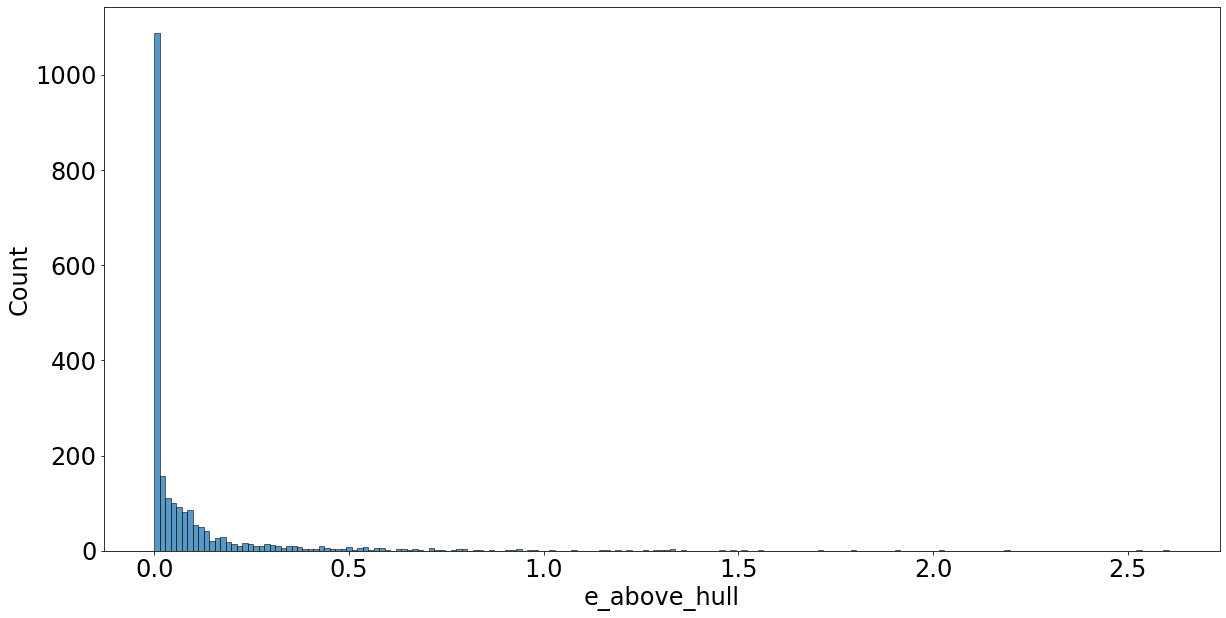

In [45]:
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['font.size'] = 24
sns.histplot(df['e_above_hull'])

In [54]:
df = df[df['e_above_hull'].isna() == False]

In [60]:
df = df.fillna(0)

In [63]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors
target = ['exfoliation_energy_per_atom (eV/atom)']

In [137]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn']
fblock = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
          'Ac', 'Th', 'Pa', 'U',  'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
d_synths = ['Rf', 'Db', 'Sg', 'Bh', 'HS', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']

bad_elements = noble_gases + fblock + d_synths

element_mask = df['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomp_mask = df['decomposition_energy (eV/atom)'] < 0.5

exfol_mask = df['exfoliation_energy_per_atom (eV/atom)'] > 0

hull_mask = df['e_above_hull'] <= 0.05

reasonable = df[element_mask & decomp_mask & exfol_mask & hull_mask]

train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [138]:
train_x_reg = np.nan_to_num(train[xenonpy_matminer_descriptors + ['e_above_hull']].to_numpy())
train_y_reg = np.nan_to_num(train[target].to_numpy())

test_x_reg = np.nan_to_num(test[xenonpy_matminer_descriptors + ['e_above_hull']].to_numpy())
test_y_reg = np.nan_to_num(test[target].to_numpy())

In [139]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg

    params = {

    }

    current_reg = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 100),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 20,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )
 
    return np.sqrt(score)

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=200),
    direction='minimize'
)

reg_study.optimize(func=objective, n_trials=1024, callbacks=[keep_best_reg])

[I 2021-08-25 18:37:23,833] A new study created in memory with name: no-name-aa067a75-be2f-497a-b969-f05b47f25986
[I 2021-08-25 18:37:23,985] Trial 0 finished with value: 0.04099807107767287 and parameters: {'max_depth': 20, 'min_child_weight': 62.21087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.04099807107767287.
[I 2021-08-25 18:37:24,007] Trial 1 pruned. Trial was pruned at iteration 3.
[I 2021-08-25 18:37:24,159] Trial 2 finished with value: 0.04073048099428889 and parameters: {'max_depth': 96, 'min_child_weight': 87.59326347420946, 'alpha': 1.7890863497893332, 'lambda': 2.5049756276172936}. Best is trial 2 with value: 0.04073048099428889.
[I 2021-08-25 18:37:24,311] Trial 3 finished with value: 0.038861643721256896 and parameters: {'max_depth': 69, 'min_child_weight': 71.27020269829002, 'alpha': 1.8512537739519748, 'lambda': 2.8059809303281247}. Best is trial 3 with value: 0.038861643721256896.
[I 2021-08-25 18:37:24,349] Tri

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


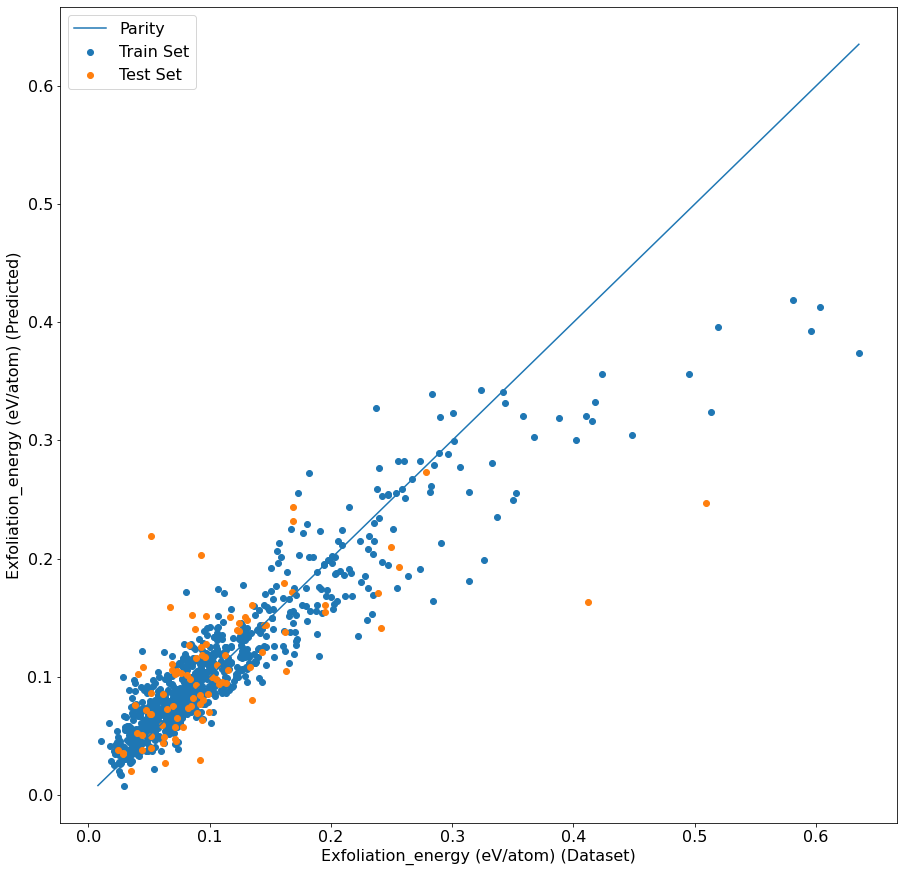

In [140]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                "Exfoliation_energy (eV/atom)",
                                                "parity.jpeg")

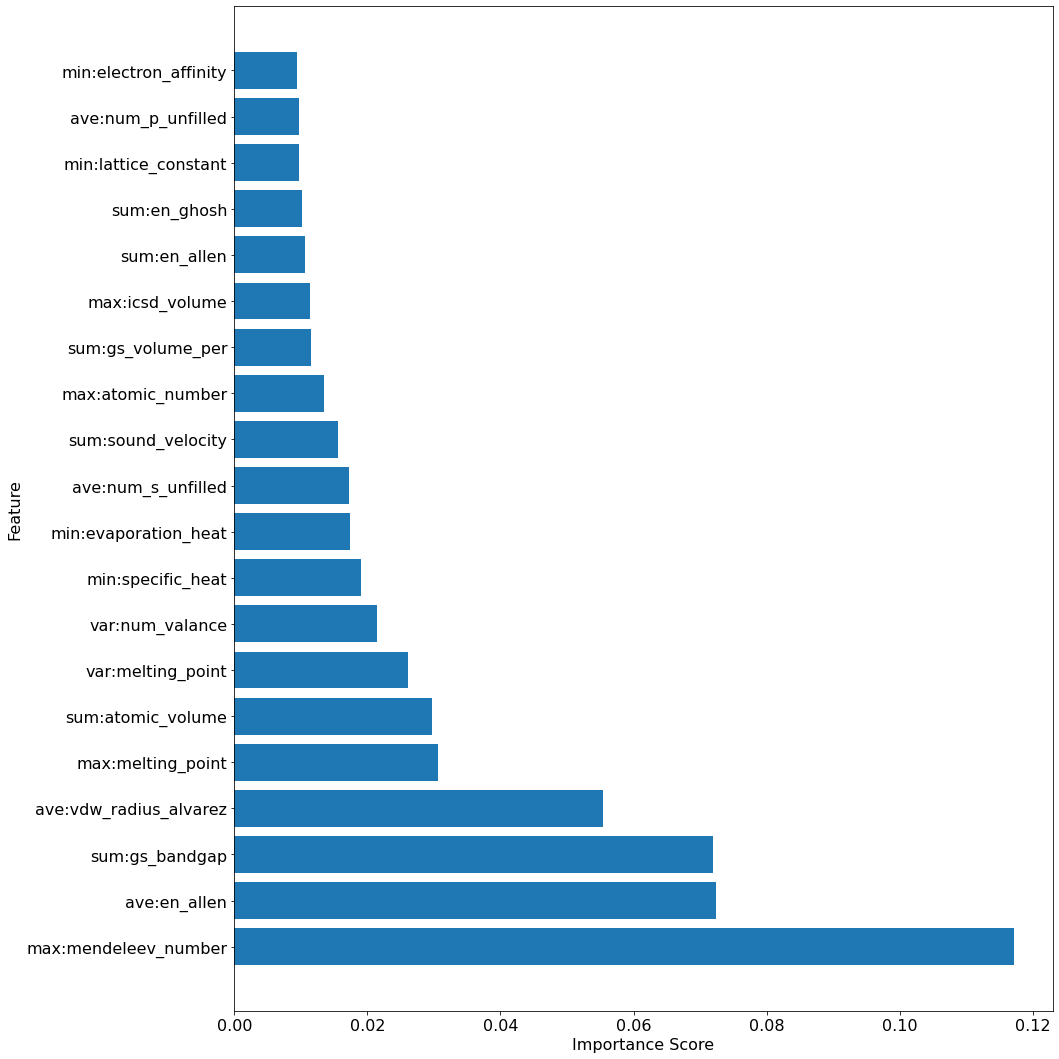

In [143]:
n_importances = 20
importances = list(zip(best_reg[1].feature_importances_, xenonpy_matminer_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

In [144]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
print("Test-Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

Test-Set Error Metrics
MaxError 0.262
MAE 0.033
MSE 0.003
RMSE 0.054
MAPE 0.347
R2 0.471
